# __Advanced Lane Finding__

## 0) Imports

In [1]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline


## 1) Load Test Images

In [2]:
test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')])
cali_images = np.array([plt.imread(i) for i in glob.glob('./camera_cal/*.jpg')])

## 2) Camera Calibration
Create a utility class for camera calibration,this is used for calibrating camera and undistorting the images

In [3]:
class camera_module():
    """
        Camera class to calibrate camera,store calibration values and perform undistortions
    """
    ret = None
    mtx = None
    dist = None
    rvecs = None
    tvecs = None
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    def camera_points_generator(self):
        """
            To generate objpoints and imgpoints from calibration images
        """
        # Based on 9x6 chessboard grid size
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg') # Directory
        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
                
    def undistort(self, img):
        """
            Undistorts an image with stored camera matrix
        """
        if self.mtx is None:
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints,
                                                                                        img.shape[:2],None,None)
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist
    
    def reset_cam(self):
        """
            Reset camera calibration values
        """
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None

## 2.1) Camera Calibration Sanity Check

In [4]:
# Initialize Camera Class and Calibrate
cam = camera_module()
cam.camera_points_generator()
print ("Camera Calibrated")

Camera Calibrated


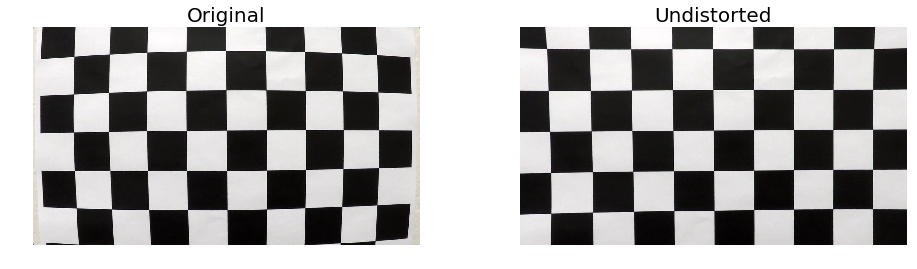

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(cali_images[0])
ax1.set_title('Original',fontsize=20)
ax1.axis('off')
ax2.imshow(cam.undistort(cali_images[0]))
ax2.set_title('Undistorted',fontsize=20)
ax2.axis('off')

test_images_cali = []
# Undistort all test images
for img in test_images:
    test_images_cali.append(cam.undistort(img))

(-0.5, 1279.5, 719.5, -0.5)

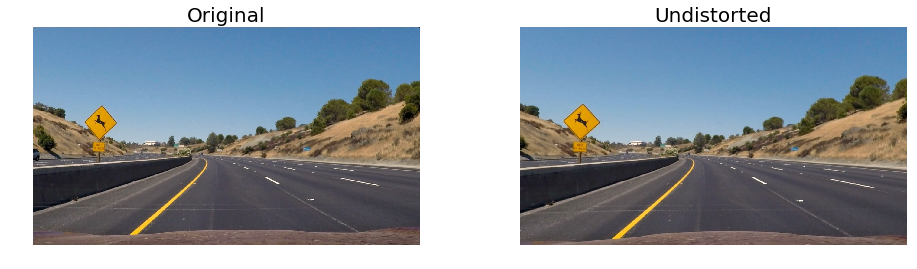

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(test_images[1])
ax1.set_title('Original',fontsize=20)
ax1.axis('off')
ax2.imshow(cam.undistort(test_images[1]))
ax2.set_title('Undistorted',fontsize=20)
ax2.axis('off')

## 3) Perpective Transform

In [7]:
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])

# Original and far
#     src = np.float32([(608,440),
#                   (677,440), 
#                   (258,682), 
#                   (1060,682)])
#     dst = np.float32([(450,0),
#                   (img_size[0]-450,0),
#                   (450,img_size[1]),
#                   (img_size[0]-450,img_size[1])])

    src = np.float32([[190, 720], [582, 457], [701, 457], [1145, 720]])
    offset = [150,0]
    dst = np.float32([src[0] + offset, np.array([src[0, 0], 0]) + offset, np.array([src[3, 0], 0]) - offset, src[3] - offset])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image,matrix and inv matrix
    return warped, M, Minv

## 3.1) Perpective Transform Sanity Check

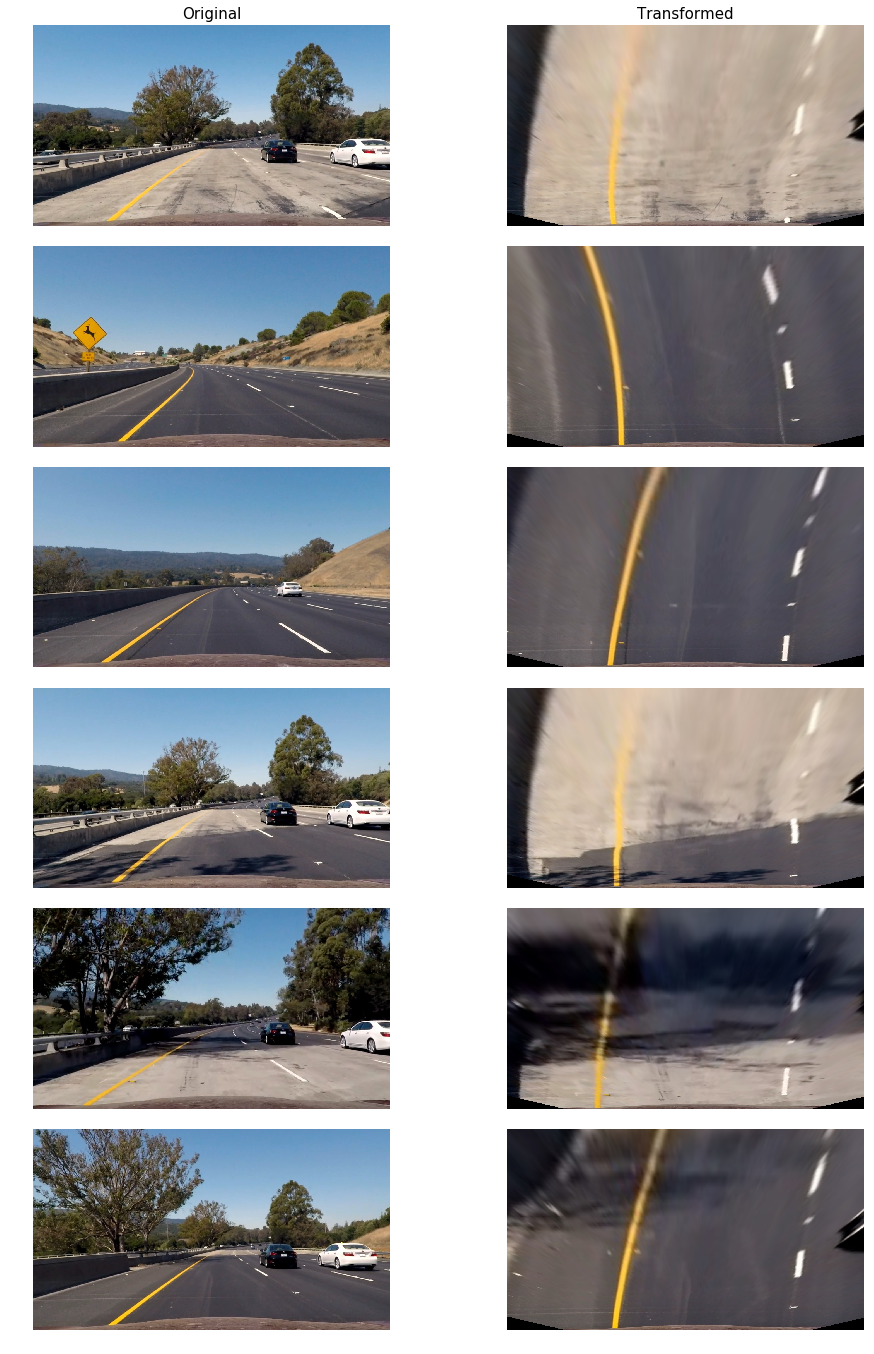

In [8]:
test_images_transformed= []

fig, ax = plt.subplots(len(test_images_cali), 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0)
ax[0][0].set_title('Original', fontsize=15)
ax[0][1].set_title('Transformed', fontsize=15)
for i in range(len(test_images_cali)) :
    ax[i,0].imshow(test_images_cali[i])
    transformed_img,M,Minv = perspective_transform(test_images_cali[i])
    test_images_transformed.append(transformed_img)
    ax[i,1].imshow(transformed_img)
for axes in ax.flatten() :
    axes.axis('off')

## 4) Color and Edge Threholding 

## Exploring Color Thresholds

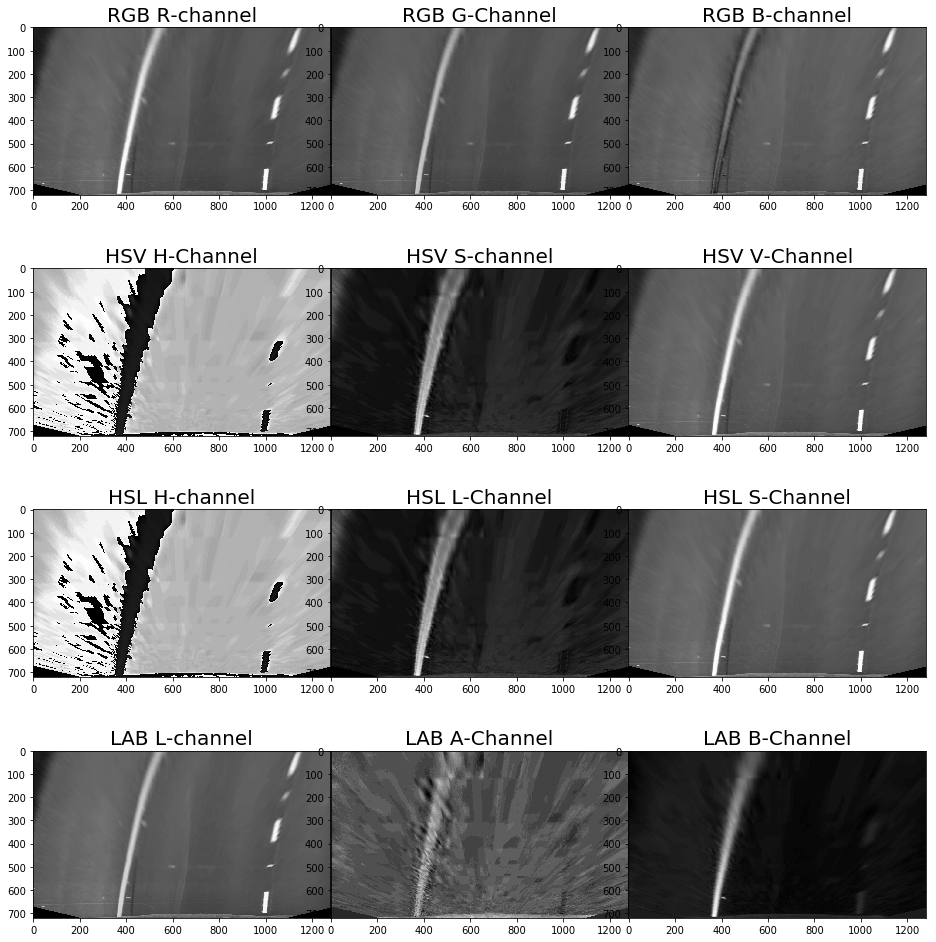

...


In [9]:
# Visualize multiple color space channels


def viz_colorspace(img):
    imgRGB_R = img[:,:,0]
    imgRGB_G = img[:,:,1]
    imgRGB_B = img[:,:,2]
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    imgHSV_H = img_HSV[:,:,0]
    imgHSV_S = img_HSV[:,:,1]
    imgHSV_V = img_HSV[:,:,2]
    img_HLS= cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    imgHLS_H = img_HSV[:,:,0]
    imgHLS_L = img_HSV[:,:,1]
    imgHLS_S = img_HSV[:,:,2]
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    imgLAB_L = img_LAB[:,:,0]
    imgLAB_A = img_LAB[:,:,1]
    imgLAB_B = img_LAB[:,:,2]
    fig, axs = plt.subplots(4,3, figsize=(16, 17))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    axs[0].imshow(imgRGB_R, cmap='gray')
    axs[0].set_title('RGB R-channel', fontsize=20)
    axs[1].imshow(imgRGB_G, cmap='gray')
    axs[1].set_title('RGB G-Channel', fontsize=20)
    axs[2].imshow(imgRGB_B, cmap='gray')
    axs[2].set_title('RGB B-channel', fontsize=20)
    axs[3].imshow(imgHSV_H, cmap='gray')
    axs[3].set_title('HSV H-Channel', fontsize=20)
    axs[4].imshow(imgHSV_S, cmap='gray')
    axs[4].set_title('HSV S-channel', fontsize=20)
    axs[5].imshow(imgHSV_V, cmap='gray')
    axs[5].set_title('HSV V-Channel', fontsize=20)
    axs[6].imshow(imgHLS_H, cmap='gray')
    axs[6].set_title('HSL H-channel', fontsize=20)
    axs[7].imshow(imgHLS_L, cmap='gray')
    axs[7].set_title('HSL L-Channel', fontsize=20)
    axs[8].imshow(imgHLS_S, cmap='gray')
    axs[8].set_title('HSL S-Channel', fontsize=20)
    axs[9].imshow(imgLAB_L, cmap='gray')
    axs[9].set_title('LAB L-channel', fontsize=20)
    axs[10].imshow(imgLAB_A, cmap='gray')
    axs[10].set_title('LAB A-Channel', fontsize=20)
    axs[11].imshow(imgLAB_B, cmap='gray')
    axs[11].set_title('LAB B-Channel', fontsize=20)
    plt.show()

viz_colorspace(test_images_transformed[2])
print('...')


### Image Processing Functions

In [10]:

def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    '''
    Applies Sobel x or y, 
    then takes an absolute value and applies a threshold.
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Applies Sobel x and y, 
    then computes the magnitude of the gradient
    and applies a threshold
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Applies Sobel x and y, 
    then computes the direction of the gradient
    and applies a threshold.
    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_b_channel(img, thresh=(190,255)):
    '''
    Applies Normalization and a threshold to the LAB B channel.
    Used to recognize yellow lane lines.
    '''
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # Don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    #  Apply a threshold
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select_channel(img, thresh = (220, 255)):
    '''
    Applies a threshold to the HLS L channel.
    Used to recognize white lane lines.
    '''
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,1]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

def gray_threshold(img,thresh=150):
    '''
    Applies a threshold to grayscale image.
    Used to recognize white/yellow lane lines.
    '''
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _, binary_output = cv2.threshold(gray,thresh,1,cv2.THRESH_BINARY)
    return binary_output

def clahe(image):
    ### Contrast Limited Adaptive Histogram Equalization
    ### http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

    img_lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    img = img_lab[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(img)
    img_lab[:,:,0] = cl
    img =  cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    return img

binary_output_sample= gray_threshold(test_images_transformed[0],thresh=150)

### Checking Road Conditions for Dynamic Thresholding

In [14]:
def road_condition(img,display=False):
    '''
    Checks Road condition based on mean Y value of YUV colorspace
    '''
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    w, h = yuv.shape[1], yuv.shape[0]
    y_channel_mean_value = np.average(yuv[:,0:550,0])
#     print (y_channel_mean_value)
    # If road is faded, low contrast
    if (y_channel_mean_value > 120):
        condition= "Faded Road"
    elif ((y_channel_mean_value <= 120) & (y_channel_mean_value > 71)):
        condition= "Normal Road"
    elif (y_channel_mean_value <= 71):
        condition= "Road with Shadows"
    if display:
        return y_channel
    left_line.road_condition = condition
#     print(condition)
    return condition

In [27]:
for img in test_images_transformed:
    road_condition(img)

### Thresholding Pipeline

In [15]:
def binarize(img):
    '''
    Combining Various thresholding processes based on road conditions to produce binary output of lane lines
    '''
    condition = road_condition(img)
    combined = np.zeros_like(binary_output_sample)
    
    if (condition == "Faded Road"):
        hls_s_binary = hls_select_channel(img, thresh=(200, 255)) 
        lab_b_binary = lab_b_channel(img,thresh = (185, 255))
        combined[(hls_s_binary == 1) |(lab_b_binary==1) ] = 1
        
    elif (condition == "Normal Road"):
        lab_b_binary = lab_b_channel(img)
        # Better white lane recognition, should only use when road is dark aka good contrast 
        hls_s_binary = hls_select_channel(img, thresh=(210, 255)) 
        combined[ (hls_s_binary == 1) |(lab_b_binary==1) ] = 1
        
    elif (condition == "Road with Shadows"):
        img = clahe(img)
        lab_b_binary = lab_b_channel(img,thresh = (185, 255))
        # Better white lane recognition, should only use when road is dark aka good contrast 
        hls_s_binary = hls_select_channel(img, thresh=(235, 255)) 
        combined[ (hls_s_binary == 1) |(lab_b_binary==1) ] = 1
    
    return combined


## 5) Masking the Region of Interest

In [19]:
def region_of_interest(img, vertices = np.array([[[220, 720], [150, 0], [1200, 0], [1100, 720]]])):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`.
    """
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # For look ahead
#     vertices = np.array([[[300, 720], [250, 0], [1200, 0], [950, 720]]])
    
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


### Thresholding and Masking Sanity Check

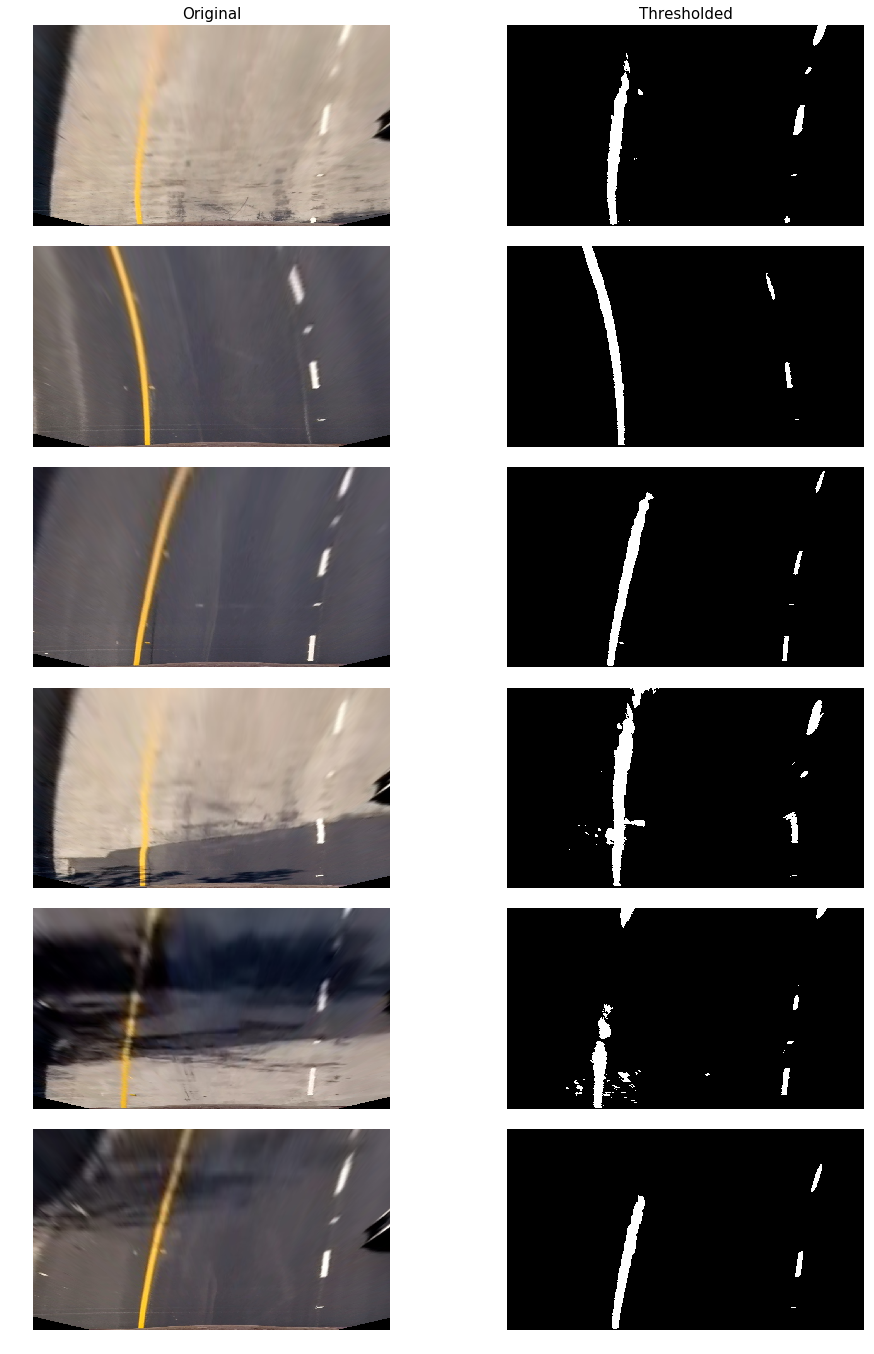

In [18]:
test_images_thresholded= []

fig, ax = plt.subplots(6, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0)
ax[0][0].set_title('Original', fontsize=15)
ax[0][1].set_title('Thresholded', fontsize=15)
for i in range(6) :
    ax[i,0].imshow(test_images_transformed[i])
    thresholded_img = region_of_interest(binarize(test_images_transformed[i]))
    test_images_thresholded.append(thresholded_img)
    ax[i,1].imshow(thresholded_img,cmap='gray')
for axes in ax.flatten() :
    axes.axis('off')

## 6) Class Attributes and Functions

### Attributes

In [20]:
class Line():
    """
        Class to store detected lane statistics and provide temporal smoothing 
    """
    def __init__(self, maxSamples=3):
        
        self.maxSamples = maxSamples 
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=self.maxSamples)
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Was the line detected in the last iteration?
        self.detected = False 
        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # Road Condition
        self.road_condition = None
         
    def update_lane(self, ally, allx):
        """
            Function to update the statistics
        """
        # Mean x value 
        self.bestx = np.mean(allx, axis=0)
        # Fit 2nd order polynomial
        new_fit = np.polyfit(ally, allx, 2)
        # Calculate the difference between last fit and new fit
        self.diffs = np.subtract(self.current_fit, new_fit)
        # Update current fit
        self.current_fit = new_fit
        # Add the new fit to the queue
        self.recent_xfitted.append(self.current_fit)
        # Use the queue mean as the best fit
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        # meters per pixel in y dimension
        ym_per_pix = 30/720
        # meters per pixel in x dimension
        xm_per_pix = 3.7/700
        # Calculate radius of curvature
        fit_cr = np.polyfit(ally*ym_per_pix, allx*xm_per_pix, 2)
        y_eval = np.max(ally)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

### Sliding Window Search

In [21]:
def window_search(img, nonzero, nonzerox, nonzeroy):
    """
    Search for lane pixels in sliding windows
    """
    # Temp image to draw detections on
    out_img = np.dstack((img, img, img))*255
    # Calculate histogram
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Take the midpoint and use the max on each side as starting point
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[0:midpoint])
    rightx_base = np.argmax(histogram[midpoint:histogram.shape[0]]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low)
                          & (nonzeroy < win_y_high)
                          & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low)
                           & (nonzeroy < win_y_high)
                           & (nonzerox >= win_xright_low)
                           & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) 
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #####=================Display===============================
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
    cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)
    
   #####=================Display===============================
    
    return left_lane_inds, right_lane_inds,out_img


## Margin Search

In [22]:
def margin_search(img, nonzero, nonzerox, nonzeroy):
    '''
    Search for lane pixels within margin from last detected line, lower computational complexity
    '''
    margin = 30
    left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin))
                      & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin))
                       & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))

    #####====================Display============================
    out_img = np.dstack((img, img, img))*255
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
    cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)
    
    #####================================================
    
    return left_lane_inds, right_lane_inds,out_img

    

## Validate Lines

In [23]:
def lane_validation_and_update(img, nonzero, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    """
    Validate Lines based on a set of rules and update the lane lines if they pass validation     
    """
    # Extract left and right line pixel positions
    left_line_allx = nonzerox[left_lane_inds]
    left_line_ally = nonzeroy[left_lane_inds] 
    right_line_allx = nonzerox[right_lane_inds]
    right_line_ally = nonzeroy[right_lane_inds]
    
    # Discard lane detections that have very little points, 
    # as they tend to have unstable results in most cases
    if len(left_line_allx) <= 1800 or len(right_line_allx) <= 1800:
        left_line.detected = False
        right_line.detected = False
        return
    
    left_x_mean = np.mean(left_line_allx, axis=0)
    right_x_mean = np.mean(right_line_allx, axis=0)
    lane_width = np.subtract(right_x_mean, left_x_mean)
    
    # Discard the detections left and right lanes are not in their repective half of their screens
    if left_x_mean > 740 or right_x_mean < 740:
        left_line.detected = False
        right_line.detected = False
        return
    
    # Discard the detections if the lane width is too large or too small
    if  lane_width < 300 or lane_width > 800:
        left_line.detected = False
        right_line.detected = False
        return 
    
    # If this is the first detection or 
    # the detection is within the margin of the averaged n last lines 
    if left_line.bestx is None or np.abs(np.subtract(left_line.bestx, np.mean(left_line_allx, axis=0))) < 100:
        left_line.update_lane(left_line_ally, left_line_allx)
        left_line.detected = True
    else:
        left_line.detected = False
    if right_line.bestx is None or np.abs(np.subtract(right_line.bestx, np.mean(right_line_allx, axis=0))) < 100:
        right_line.update_lane(right_line_ally, right_line_allx)
        right_line.detected = True
    else:
        right_line.detected = False
    
    # Calculate the distance of car from center of lane
    lane_center = right_line.bestx - left_line.bestx
    left_line.line_base_pos = ((img.shape[1]*0.5 - lane_center)*3.7)/700
    right_line.line_base_pos = left_line.line_base_pos
    

### Finding Lane Lines Logic

In [24]:
def find_lanes(img):
    """
        Lane finding logic that decides which lane finding function to use and returns img for visualization 
        (based on weather sliding or margin search was used)
        
    """
    # Get the foreground pixals
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # If the last detection was successful take the non zero pixals within the 30 pixal margin as the new detections
    if left_line.detected and right_line.detected:
        # Margin Search
        left_lane_inds, right_lane_inds,out_img = margin_search(img, nonzero, nonzerox, nonzeroy)
        # Update the lane detections
        lane_validation_and_update(img, nonzero, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    # If first detection or the last detection was unsuccessful perform a sliding window search
    else:
        # Window Search
        left_lane_inds, right_lane_inds,out_img = window_search(img, nonzero, nonzerox, nonzeroy)
        # Update the lane detections
        lane_validation_and_update(img, nonzero, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    return out_img

## Video Annotation and Drawing

In [25]:
def write_stats(img):
    """
        To annotate Driving video with stats
    """
    font = cv2.FONT_HERSHEY_DUPLEX
    size = 1
    weight = 2
    color = (255,255,255)
    
    radius_of_curvature = (right_line.radius_of_curvature + right_line.radius_of_curvature)/2
    cv2.putText(img,'Radius of Lane Curvature : '+ '{0:.2f}'.format(radius_of_curvature)+'m',(30,60), font, size, color, weight)
    cv2.putText(img,'Road Condition: '+ '{}'.format(left_line.road_condition),(30,140), font, size, color, weight)
    if (left_line.line_base_pos >=0):
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(left_line.line_base_pos*100)+'cm'+ ' Right of Center',(30,100), font, size, color, weight)
    else:
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(abs(left_line.line_base_pos*100))+'cm' + ' Left of Center',(30,100), font, size, color, weight)
        
    
def write_diagnostic_stats(img):
    """
        Write diagnostic stats for debuggingn
    """
    font = cv2.FONT_HERSHEY_DUPLEX
    size = 1
    weight = 2
    color = (255,255,255)
    
    radius_of_curvature = (right_line.radius_of_curvature + right_line.radius_of_curvature)/2
    cv2.putText(img,'Radius of Lane Curvature : '+ '{0:.2f}'.format(radius_of_curvature)+' m',(10,60), font, size, color, weight)
    cv2.putText(img,'Left Lane Pos: '+ '{0:.2f}'.format(left_line.bestx),(10,100), font, size, color, weight)
    cv2.putText(img,'Right Lane Pos: '+ '{0:.2f}'.format(right_line.bestx),(10,130), font, size, color, weight)
    
    if (left_line.line_base_pos >=0):
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(left_line.line_base_pos)+'m'+ ' Right of Center',(10,100), font, size, color, weight)
    else:
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(abs(left_line.line_base_pos))+'m' + ' Left of Center',(10,180), font, size, color, weight)
    
def draw_lane(undist, img, Minv):
    """
    Draw the detected lanes as a polygon back to undistorted image 
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    
    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (100, 45, 155))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
        write_stats(result)
        return result
    return undist

## Build Frame


In [26]:
def build_frame(perspective_transform, threshold_img, polynomial_img, drawn_lane):
    '''
    Stitch together frames for debugging view
    '''
    # Define output image
    # Main image
    img_out=np.zeros((720,1707,3), dtype=np.uint8)
    img_out[0:720,0:1280,:] = drawn_lane
    
    # Text formatting
    fontScale=1
    thickness=1
    fontFace = cv2.FONT_HERSHEY_DUPLEX
    
    
    # Perspective transform image
    img_out[0:240,1281:1707,:] = cv2.resize(perspective_transform,(426,240))
    boxsize, _ = cv2.getTextSize("Transformed", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Transformed", (int(1494-boxsize[0]/2),40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
   
    # Threshold image
    resssized = cv2.resize(threshold_img,(426,240))
    resssized=np.uint8(resssized)
    gray_image = cv2.cvtColor(resssized*255,cv2.COLOR_GRAY2RGB)
    img_out[241:481,1281:1707,:] = cv2.resize(gray_image,(426,240))
    boxsize, _ = cv2.getTextSize("Threshold image", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Threshold image", (int(1494-boxsize[0]/2),281), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
 
    # Polynomial lines
    img_out[480:720,1281:1707,:] = cv2.resize(polynomial_img*255,(426,240))
    boxsize, _ = cv2.getTextSize("Polynomial lines", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Polynomial lines", (int(1494-boxsize[0]/2),521), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    return img_out

## Overall Pipeline

In [27]:
def process_image(image):
    """
        Wrapper function for all image processing
    """
    # Undistort the image
    undist = cam.undistort(image)
    
    # Perpective Transform
    warped,M,Minv = perspective_transform(undist)
    
    # Apply Thresholding and binarize
    binary = binarize(warped)
    
    # Mask Area of Interest
    binary_masked = region_of_interest(binary)
    
    # Find Lanes
    out_img=find_lanes(binary)
    
    # Draw lanes on image
    drawn_lane = draw_lane(undist, binary, Minv);    
    
    # stitch frames together
    result = build_frame(warped,binary,out_img,drawn_lane)
 
    return result

## Sanity Check

...


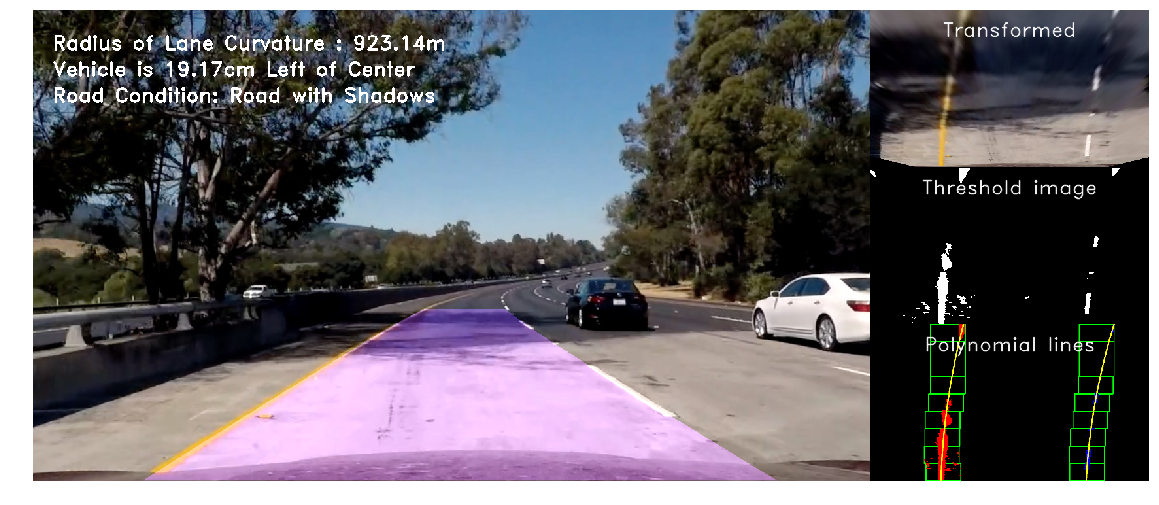

In [30]:
left_line = Line()
right_line = Line()

plt.figure(figsize = (20,20))
plt.imshow(process_image(test_images[4]))
plt.axis("off")
print ("...")

In [31]:
# Initialize Left and Right Lanes
left_line = Line()
right_line = Line()
# Reset and Calibrate
cam.reset_cam()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [02:48<00:00,  7.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

